In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/FaceNet")

#### **Face embedding**

In [ ]:

import tensorflow as tf


In [ ]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
import h5py
f = h5py.File('./model/facenet_keras.h5', 'r')
f

<HDF5 file "facenet_keras.h5" (mode r)>

In [ ]:
import h5py

def print_structure(weight_file_path):
    """
    Prints out the structure of HDF5 file.
    Args:
      weight_file_path (str) : Path to the file to analyze
    """
    f = h5py.File(weight_file_path)
    try:
        if len(f.attrs.items()):
            print("{} contains: ".format(weight_file_path))
            print("Root attributes:")
        for key, value in f.attrs.items():
            print("  {}: {}".format(key, value))

        if len(f.items())==0:
            return 

        for layer, g in f.items():
            print("  {}".format(layer))
            print("    Attributes:")
            for key, value in g.attrs.items():
                print("      {}: {}".format(key, value))

            print("    Dataset:")
            for p_name in g.keys():
                param = g[p_name]
                subkeys = param.keys()
                for k_name in param.keys():
                    print("      {}/{}: {}".format(p_name, k_name, param.get(k_name)[:]))
    finally:
        f.close()
 
try:
    print_structure('./model/facenet_keras.h5')
except:
    pass

./model/facenet_keras.h5 contains: 
Root attributes:
  backend: tensorflow
  keras_version: 2.1.2
  model_config: {"class_name": "Model", "config": {"name": "inception_resnet_v1", "layers": [{"name": "input_1", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 160, 160, 3], "dtype": "float32", "sparse": false, "name": "input_1"}, "inbound_nodes": []}, {"name": "Conv2d_1a_3x3", "class_name": "Conv2D", "config": {"name": "Conv2d_1a_3x3", "trainable": true, "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound

In [ ]:

from tensorflow import keras
from keras.models import load_model
# load model
model = load_model('./model/facenet_keras.h5')
# input and output format
print(model.inputs)
print(model.outputs)


Instructions for updating:
Colocations handled automatically by placer.
[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(?, 128) dtype=float32>]


In [ ]:
import numpy as np
# load data_bw.npz
data = np.load('./data_bw.npz')
trainX,  trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (1065, 160, 160, 3) (1065,) (452, 160, 160, 3) (452,)


In [ ]:
# define a function to get the embedding for each face
def get_embedding(model, face_pixels):
    # standardization
    face_pixels = face_pixels.astype('float32')
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # expand the dimension
    samples = np.expand_dims(face_pixels, axis=0)
    # get embedding resut
    yhat = model.predict(samples)
    return yhat[0]

# represent the faces in the training data as embeddings
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX  =  np.asarray(newTrainX)
print(newTrainX.shape)

# represent the faces in the test data as embeddings
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)


np.savez_compressed('data_bw-embeddings.npz', newTrainX, trainy, newTestX, testy)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(1065, 128)
(452, 128)


#### **Face Classification**

In [ ]:
import numpy as np
data = np.load('data_bw-embeddings.npz')
trainX, trainy, testX, testy =  data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

# normalize face embedding vectors
from sklearn.preprocessing import Normalizer
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# encode target values
from sklearn.preprocessing import LabelEncoder
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

Dataset: train=1065, test=452


In [ ]:
trainX[0] # embedding for the first image

array([ 0.01029229, -0.09442393,  0.060505  ,  0.03726705, -0.02909969,
       -0.02527452,  0.08709612, -0.01154955,  0.00326058, -0.01399028,
        0.2250736 , -0.18941823, -0.00290601, -0.04865242, -0.04521634,
        0.04288867,  0.09229906,  0.01187887, -0.06859475,  0.02509333,
        0.06966079, -0.00409737,  0.10477807,  0.05520479, -0.00842314,
        0.06443547, -0.06151197, -0.03816632,  0.03345086, -0.1689236 ,
       -0.09909207,  0.08046939, -0.08549454,  0.00965029,  0.23989448,
        0.02482407, -0.00459584,  0.05512245, -0.05083865, -0.00317535,
        0.08023337, -0.0233741 ,  0.14422372,  0.01579269,  0.06751268,
       -0.19283906,  0.08987341,  0.05337192,  0.09166168,  0.11468607,
        0.06971838, -0.02105869, -0.05768323, -0.13982096, -0.02068013,
        0.10981226,  0.15323524,  0.08225756, -0.02265113, -0.0121052 ,
        0.01573232, -0.03199221, -0.00428425,  0.02068028, -0.1458994 ,
        0.12745601,  0.10385458, -0.04120296,  0.00056921,  0.03

In [ ]:
from sklearn.svm import SVC
# use SVM
model = SVC()
model.fit(trainX, trainy)

from sklearn.metrics import accuracy_score
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# accuracy
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# result
print('Accuracy: train=%.3f, test=%.3f'  %  (score_train*100,  score_test*100))


Accuracy: train=100.000, test=98.009


In [ ]:
class_names = ['Arjun_Rampal', 'Arshad_Warsi', 'Asin', 'Ayushmann_Khurrana', 'Bhumi_Pednekar', 'Bipasha_Basu', 'Bobby_Deol', 'Deepika_Padukone', 'Disha_Patani', 'Emraan_Hashmi', 'Esha_Gupta', 'Farhan_Akhtar', 'Govinda']

from sklearn.metrics import classification_report
print(classification_report(testy, yhat_test, target_names=class_names,digits=4))

                    precision    recall  f1-score   support

      Arjun_Rampal     1.0000    1.0000    1.0000        31
      Arshad_Warsi     1.0000    0.9677    0.9836        31
              Asin     0.9783    1.0000    0.9890        45
Ayushmann_Khurrana     1.0000    1.0000    1.0000        38
    Bhumi_Pednekar     0.9697    1.0000    0.9846        32
      Bipasha_Basu     1.0000    1.0000    1.0000        38
        Bobby_Deol     1.0000    1.0000    1.0000        22
  Deepika_Padukone     0.9048    0.9828    0.9421        58
      Disha_Patani     1.0000    0.9130    0.9545        46
     Emraan_Hashmi     1.0000    1.0000    1.0000        29
        Esha_Gupta     1.0000    0.9412    0.9697        34
     Farhan_Akhtar     0.9600    1.0000    0.9796        24
           Govinda     1.0000    0.9583    0.9787        24

          accuracy                         0.9801       452
         macro avg     0.9856    0.9818    0.9832       452
      weighted avg     0.9813    0.980

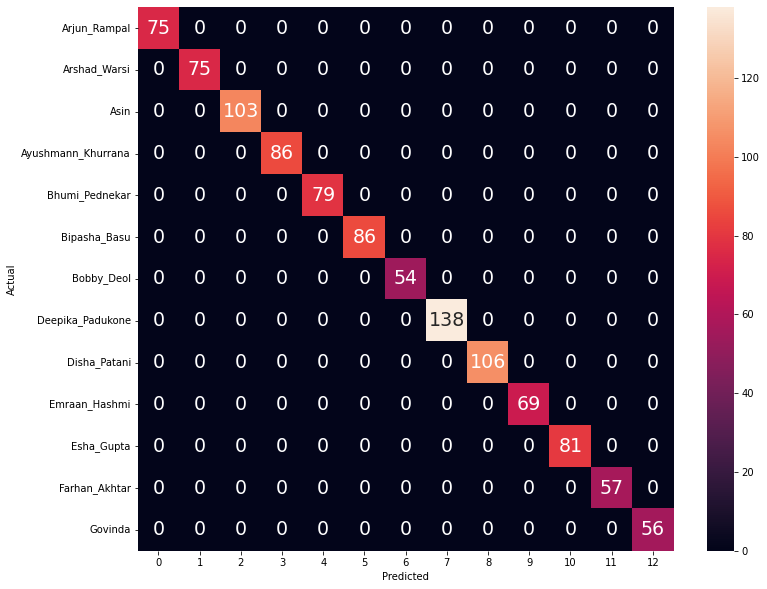

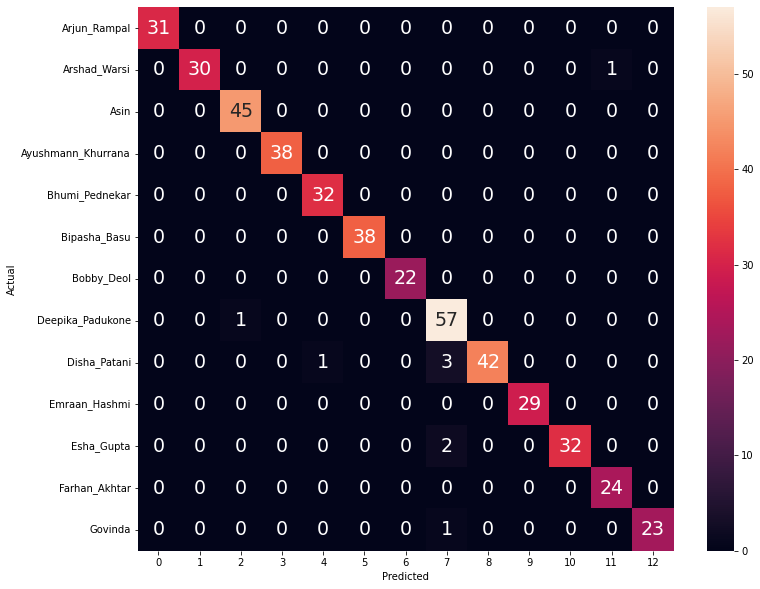

In [ ]:
# plot the confusion matrix

from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# train confusion matrix
data = confusion_matrix(trainy, yhat_train)
df_cm = pd.DataFrame(data, columns=np.unique(trainy), index = np.unique(trainy))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (12, 10))
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 19},yticklabels=class_names) 

# test confusion matrix
data = confusion_matrix(testy, yhat_test)
df_cm = pd.DataFrame(data, columns=np.unique(testy), index = np.unique(testy))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (12, 10))
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 19},yticklabels=class_names) 


In [ ]:
# SVM
np.random.seed(4012)
from sklearn.svm import SVR
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    'C': stats.uniform(0,50),
    "kernel":['poly','rbf','sigmoid']
}
n_iter_search=60
clf = SVC(gamma='scale')
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='neg_mean_squared_error')
Random.fit(trainX, trainy)
print(Random.best_params_)
print("MSE:"+ str(-Random.best_score_))

{'C': 0.31045301704716866, 'kernel': 'rbf'}
MSE:0.23474178403755872


In [ ]:
# SVM after hyper-parameter tuning
from sklearn.svm import SVC
model = SVC()
model.set_params(**Random.best_params_)
model.fit(trainX, trainy)

from sklearn.metrics import accuracy_score
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# accuracy
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# result
print('Accuracy: train=%.3f, test=%.3f'  %  (score_train*100,  score_test*100))
print(score_test)

Accuracy: train=99.155, test=98.230
0.9823008849557522


In [ ]:
print(classification_report(testy, yhat_test, target_names=class_names,digits=4))

                    precision    recall  f1-score   support

      Arjun_Rampal     1.0000    1.0000    1.0000        31
      Arshad_Warsi     1.0000    0.9677    0.9836        31
              Asin     0.9783    1.0000    0.9890        45
Ayushmann_Khurrana     1.0000    1.0000    1.0000        38
    Bhumi_Pednekar     1.0000    0.9688    0.9841        32
      Bipasha_Basu     1.0000    1.0000    1.0000        38
        Bobby_Deol     1.0000    1.0000    1.0000        22
  Deepika_Padukone     0.9048    0.9828    0.9421        58
      Disha_Patani     1.0000    0.9348    0.9663        46
     Emraan_Hashmi     1.0000    1.0000    1.0000        29
        Esha_Gupta     1.0000    0.9412    0.9697        34
     Farhan_Akhtar     0.9600    1.0000    0.9796        24
           Govinda     1.0000    1.0000    1.0000        24

          accuracy                         0.9823       452
         macro avg     0.9879    0.9842    0.9857       452
      weighted avg     0.9835    0.982

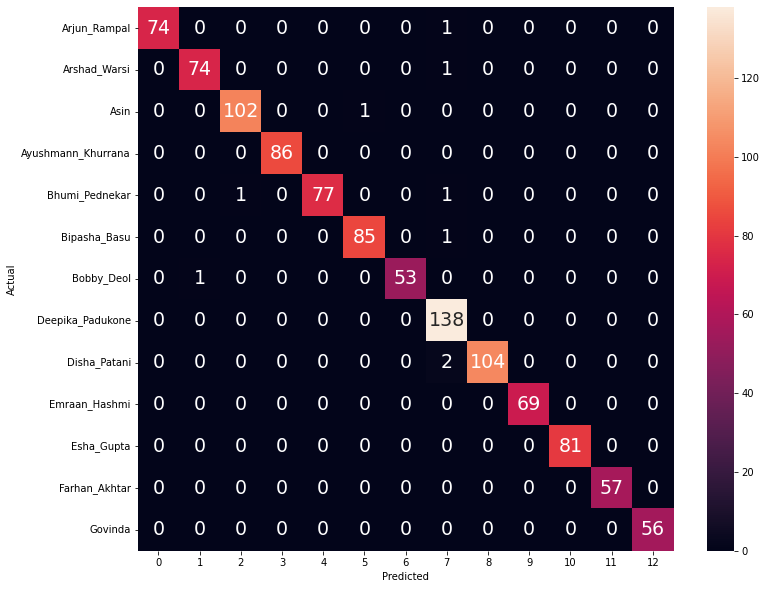

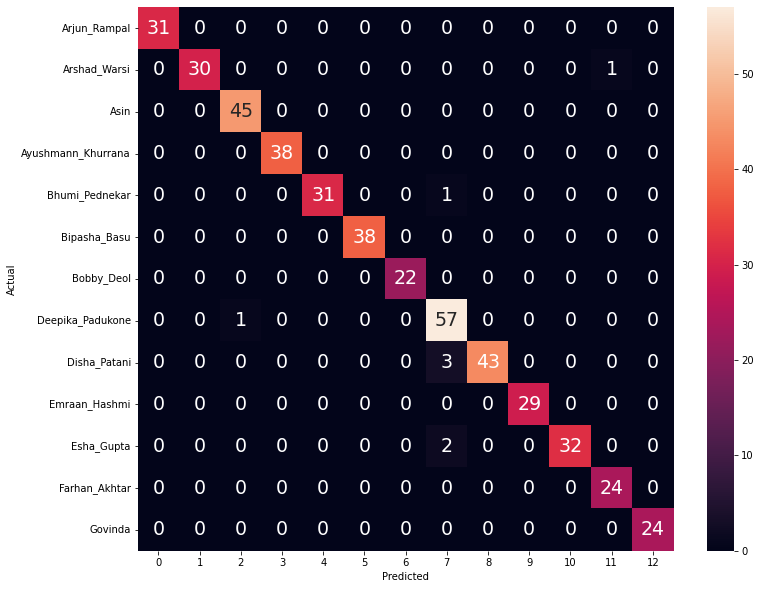

In [ ]:
# plot the confusion matrix

from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# train confusion matrix
data = confusion_matrix(trainy, yhat_train)
df_cm = pd.DataFrame(data, columns=np.unique(trainy), index = np.unique(trainy))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (12, 10))
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 19},yticklabels=class_names) 

# test confusion matrix
data = confusion_matrix(testy, yhat_test)
df_cm = pd.DataFrame(data, columns=np.unique(testy), index = np.unique(testy))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (12, 10))
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 19},yticklabels=class_names) 


In [ ]:
# MLP in sklearn
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(trainX, trainy)
score_test= clf.score(testX, testy)
score_train = clf.score(trainX, trainy)
yhat_test = clf.predict(testX)
yhat_train = clf.predict(trainX)

print('Accuracy: train=%f, test=%f'  %  (score_train*100,  score_test*100))

Accuracy: train=100.000000, test=98.230088


In [ ]:
print(classification_report(testy, yhat_test, target_names=class_names,digits=4))


                    precision    recall  f1-score   support

      Arjun_Rampal     1.0000    1.0000    1.0000        31
      Arshad_Warsi     1.0000    0.9677    0.9836        31
              Asin     0.9783    1.0000    0.9890        45
Ayushmann_Khurrana     1.0000    1.0000    1.0000        38
    Bhumi_Pednekar     0.9697    1.0000    0.9846        32
      Bipasha_Basu     1.0000    1.0000    1.0000        38
        Bobby_Deol     1.0000    1.0000    1.0000        22
  Deepika_Padukone     0.9194    0.9828    0.9500        58
      Disha_Patani     1.0000    0.9130    0.9545        46
     Emraan_Hashmi     1.0000    1.0000    1.0000        29
        Esha_Gupta     1.0000    0.9412    0.9697        34
     Farhan_Akhtar     1.0000    1.0000    1.0000        24
           Govinda     0.9600    1.0000    0.9796        24

          accuracy                         0.9823       452
         macro avg     0.9867    0.9850    0.9855       452
      weighted avg     0.9832    0.982

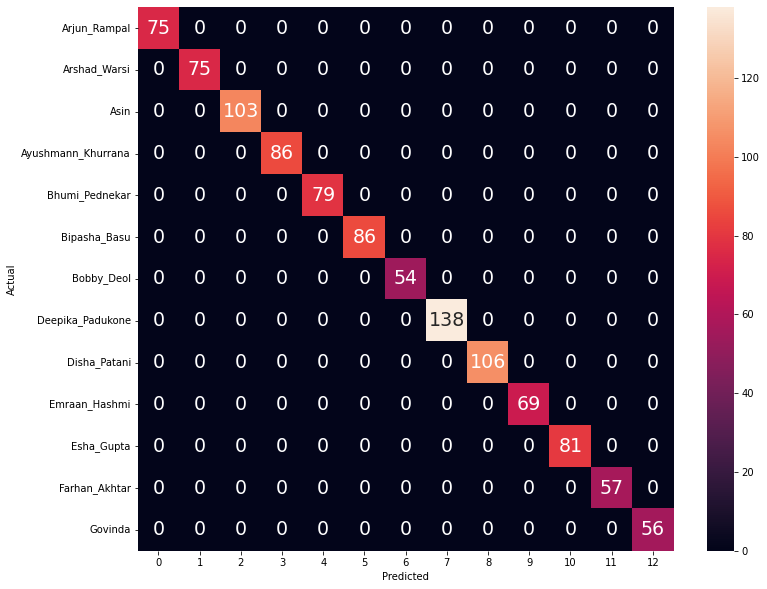

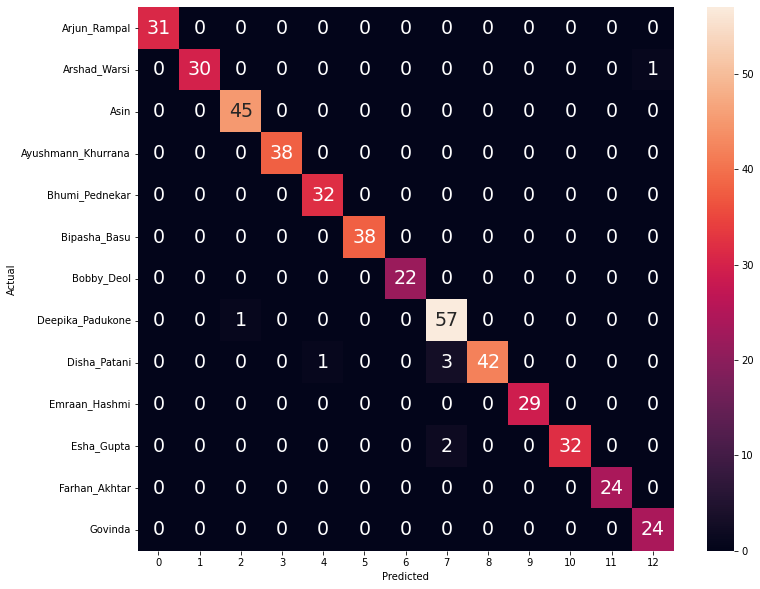

In [ ]:
# plot the confusion matrix

from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# train confusion matrix
data = confusion_matrix(trainy, yhat_train)
df_cm = pd.DataFrame(data, columns=np.unique(trainy), index = np.unique(trainy))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (12, 10))
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 19},yticklabels=class_names) 

# test confusion matrix
data = confusion_matrix(testy, yhat_test)
df_cm = pd.DataFrame(data, columns=np.unique(testy), index = np.unique(testy))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (12, 10))
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 19}, yticklabels=class_names) 


In [ ]:
# self-written MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(13, activation = "softmax"))
model.compile(optimizer='adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

# train
model.fit(trainX, trainy, epochs=100)

Train on 1065 samples
Epoch 1/100
1065/1065 [==============================] - 0s 184us/sample - loss: 2.2568 - acc: 0.6535
Epoch 2/100
1065/1065 [==============================] - 0s 69us/sample - loss: 1.4785 - acc: 0.9455
Epoch 3/100
1065/1065 [==============================] - 0s 65us/sample - loss: 0.7442 - acc: 0.9718
Epoch 4/100
1065/1065 [==============================] - 0s 65us/sample - loss: 0.3840 - acc: 0.9737
Epoch 5/100
1065/1065 [==============================] - 0s 74us/sample - loss: 0.2371 - acc: 0.9822
Epoch 6/100
1065/1065 [==============================] - 0s 71us/sample - loss: 0.1735 - acc: 0.9822
Epoch 7/100
1065/1065 [==============================] - 0s 66us/sample - loss: 0.1378 - acc: 0.9831
Epoch 8/100
1065/1065 [==============================] - 0s 81us/sample - loss: 0.1167 - acc: 0.9831
Epoch 9/100
1065/1065 [==============================] - 0s 70us/sample - loss: 0.0965 - acc: 0.9859
Epoch 10/100
1065/1065 [==============================] - 0s 68us/sa

In [ ]:
# fit
from sklearn.metrics import classification_report
y_pred = model.predict(testX)
y_pred = np.array([np.argmax(i) for i in y_pred])
y_pred.shape
print(classification_report(testy, y_pred,target_names=class_names,digits=4))
y_pred_train = model.predict(trainX)
y_pred_train = np.array([np.argmax(i) for i in y_pred_train])

score_train = np.mean(y_pred_train==trainy)
score_test = np.mean(y_pred==testy)
print('Accuracy: train=%f, test=%f'  %  (score_train*100,  score_test*100))

# slef-written MLP gives the same result as the one in sklearn

                    precision    recall  f1-score   support

      Arjun_Rampal     1.0000    1.0000    1.0000        31
      Arshad_Warsi     1.0000    0.9677    0.9836        31
              Asin     0.9783    1.0000    0.9890        45
Ayushmann_Khurrana     1.0000    1.0000    1.0000        38
    Bhumi_Pednekar     0.9697    1.0000    0.9846        32
      Bipasha_Basu     1.0000    1.0000    1.0000        38
        Bobby_Deol     1.0000    1.0000    1.0000        22
  Deepika_Padukone     0.9194    0.9828    0.9500        58
      Disha_Patani     1.0000    0.9130    0.9545        46
     Emraan_Hashmi     1.0000    1.0000    1.0000        29
        Esha_Gupta     1.0000    0.9412    0.9697        34
     Farhan_Akhtar     1.0000    1.0000    1.0000        24
           Govinda     0.9600    1.0000    0.9796        24

          accuracy                         0.9823       452
         macro avg     0.9867    0.9850    0.9855       452
      weighted avg     0.9832    0.982